CNN-Powered CAPTCHA Solver
Build a CNN model that can decode distorted alphanumeric CAPTCHA images 

In [1]:
!pip install captcha 

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install opencv-python



Defaulting to user installation because normal site-packages is not writeable


Phase 1: Data Generation
In this we create a folder of characters (A-Z, 0-9), and save images in each folder.

In [1]:
import os 
import string
import random
from captcha.image import ImageCaptcha
from PIL import Image #python imaging library used for reading, creating, editing, saving images in Python

In [2]:
#Define Character set
characters= list(string.ascii_uppercase + string.digits)
print(f"Total characters : {len(characters)}")

Total characters : 36


In [3]:
#Create a dataset/ folder with 36 subfolders each for one character
base_dir="captcha_dataset"
for char in characters:
    os.makedirs(os.path.join(base_dir, char), exist_ok =True)

In [4]:
#Generate Captcha images and save them in the folder
image=ImageCaptcha(height=60 , width=60)
def generate_image(n_per_class=400):
    for char in characters:
        for i in range(n_per_class):
            img=image.generate_image(char)
            file_path=os.path.join(base_dir, char, f"{char}_{i}.png")
            img.save(file_path)

generate_image(n_per_class=400)

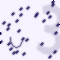

In [5]:
from IPython.display import Image as IPImage, display #IPImage loads an image from a file path, renaming Image as IPImage to avoid confusion between PIL's Image class.
def preview_random_image():
    random_char=random.choice(characters)
    folder=os.path.join(base_dir, random_char)
    img_file=random.choice(os.listdir(folder))
    display(IPImage(filename=os.path.join(folder, img_file)))

preview_random_image()

Phase 2: Image Preprocessing
In this step we will clean, resize and normalize the images into NumPy arrays so that the CNN model would understand

In [6]:
import cv2
import numpy as np 
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [7]:
char_to_index= {char: idx for idx, char in enumerate(characters)}
print(char_to_index)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, '0': 26, '1': 27, '2': 28, '3': 29, '4': 30, '5': 31, '6': 32, '7': 33, '8': 34, '9': 35}


In [8]:
def load_data(dataset_dir="captcha_dataset", image_size=(60, 60)):
    X = []
    y = []

    for char in os.listdir(dataset_dir):
        folder_path = os.path.join(dataset_dir, char)

        # Skip non-folders (safety check)
        if not os.path.isdir(folder_path):
            continue
        for file_name in os.listdir(folder_path):
            if not file_name.endswith(".png"):
                continue  # Skip non-PNG files

            img_path = os.path.join(folder_path, file_name)

            # Read image as grayscale
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # Skip unreadable images
            if img is None:
                print(f" Skipping unreadable image: {img_path}")
                continue

            # Resize to target shape
            img = cv2.resize(img, image_size)

            # Normalize pixel values to [0, 1]
            img = img.astype("float32") / 255.0

            # Add channel dimension: (60, 60, 1)
            img = np.expand_dims(img, axis=-1)

            # Store image and label
            X.append(img)
            y.append(char_to_index[char])

    # Convert to NumPy arrays
    X = np.array(X)
    y = to_categorical(y, num_classes=len(characters))

    # Split into training & testing sets
    return train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = load_data()


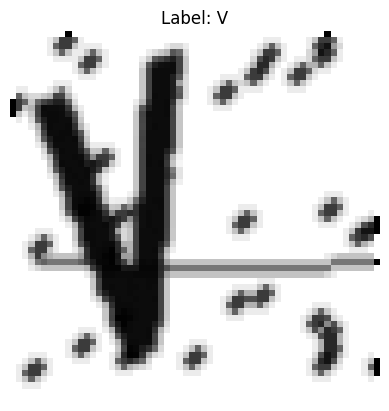

In [9]:
import matplotlib.pyplot as plt

plt.imshow(X_train[0].reshape(60,60), cmap="gray")
plt.title(f"Label: {characters[np.argmax(y_train[0])]}")
plt.axis("off")
plt.show()


Phase 3: CNN Architecture

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [26]:
model=Sequential([
    #Block1
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(60,60,1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    #Block2
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    #Flatten and dense layers (Fully connected layers)
    Flatten(),
    Dense(units=128, activation='relu'),
    Dropout(0.4),
    Dense(units=len(characters), activation='softmax') #Output layer
])

In [27]:
#Compiling the model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
model.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(),
    metrics=['accuracy']

)

Phase 4: Training the model

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)



In [29]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,            
    batch_size=64,        
    verbose=1,                # Shows you the progress
    callbacks=[early_stop]
)


Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 55s 273ms/step - accuracy: 0.0809 - loss: 3.6183 - val_accuracy: 0.0392 - val_loss: 6.5353
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 51s 281ms/step - accuracy: 0.2793 - loss: 2.3886 - val_accuracy: 0.0306 - val_loss: 36.3683
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 50s 280ms/step - accuracy: 0.4562 - loss: 1.6829 - val_accuracy: 0.0340 - val_loss: 28.8658
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 51s 282ms/step - accuracy: 0.5980 - loss: 1.1718 - val_accuracy: 0.6490 - val_loss: 1.0481
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 51s 283ms/step - accuracy: 0.6802 - loss: 0.9160 - val_accuracy: 0.6535 - val_loss: 1.8467
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 50s 280ms/step - accuracy: 0.7438 - loss: 0.7238 - val_accuracy: 0.7858 - val_loss: 0.7108
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 50s 279ms/step - accuracy: 0.7825 - loss: 0.6025 - val_accuracy: 0.8663 - val_loss: 0.4105
Epoch 8/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 50s 276ms/step - accuracy: 0.8164 - loss:

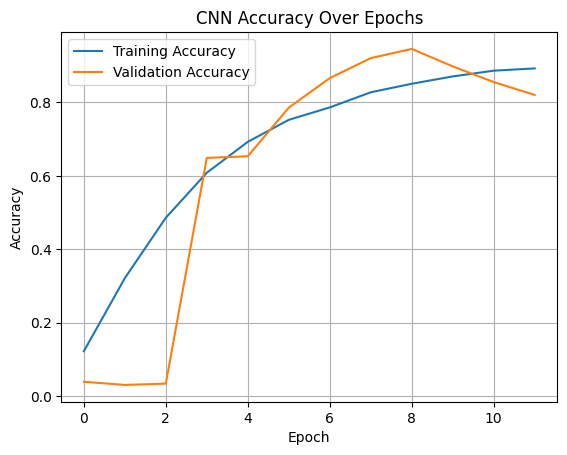

In [30]:
#Visualisation
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


Phase 5: Testing

In [35]:

from tensorflow.keras.preprocessing.image import load_img, img_to_array

# pick a random folder (i.e. character)
random_char = random.choice(characters)
folder_path = os.path.join(base_dir, random_char)

# pick a random image from that character’s folder
random_img = random.choice(os.listdir(folder_path))
img_path = os.path.join(folder_path, random_img)


In [36]:
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # grayscale
img = cv2.resize(img, (60, 60))                  # resize
img = img.astype("float32") / 255.0              # normalize
img = np.expand_dims(img, axis=-1)               # add channel dimension
img = np.expand_dims(img, axis=0)                # add batch dimension (1, 60, 60, 1)


In [37]:
#Prediction
pred = model.predict(img)
predicted_index = np.argmax(pred)
predicted_char = characters[predicted_index]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


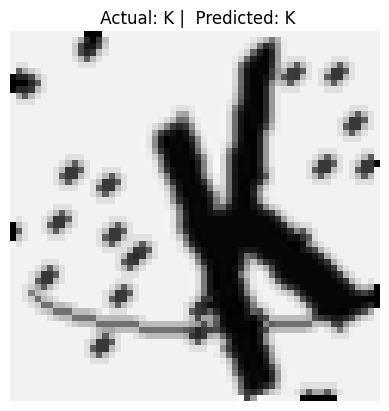

In [38]:
plt.imshow(img[0].reshape(60,60), cmap="gray")
plt.title(f" Actual: {random_char} |  Predicted: {predicted_char}")
plt.axis("off")
plt.show()


In [40]:
model.save("captcha_model.keras")


In [41]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")


90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9433 - loss: 0.1769
Test Accuracy: 94.58%


In [47]:
report = classification_report(y_true_labels, y_pred_labels, target_names=characters)
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

           A       0.98      1.00      0.99       101
           B       0.82      0.99      0.89        81
           C       0.98      0.93      0.95        68
           D       0.87      0.96      0.91        74
           E       1.00      0.96      0.98        75
           F       0.96      1.00      0.98        79
           G       0.98      0.97      0.97        58
           H       0.98      0.99      0.98        84
           I       0.99      0.94      0.96        78
           J       0.96      1.00      0.98        87
           K       1.00      0.96      0.98        93
           L       0.98      0.97      0.97        90
           M       0.98      0.97      0.98        66
           N       1.00      0.96      0.98        90
           O       0.68      0.71      0.69        85
           P       0.96      1.00      0.98        86
           Q       1.00      0.99      0.99        85
   

90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step


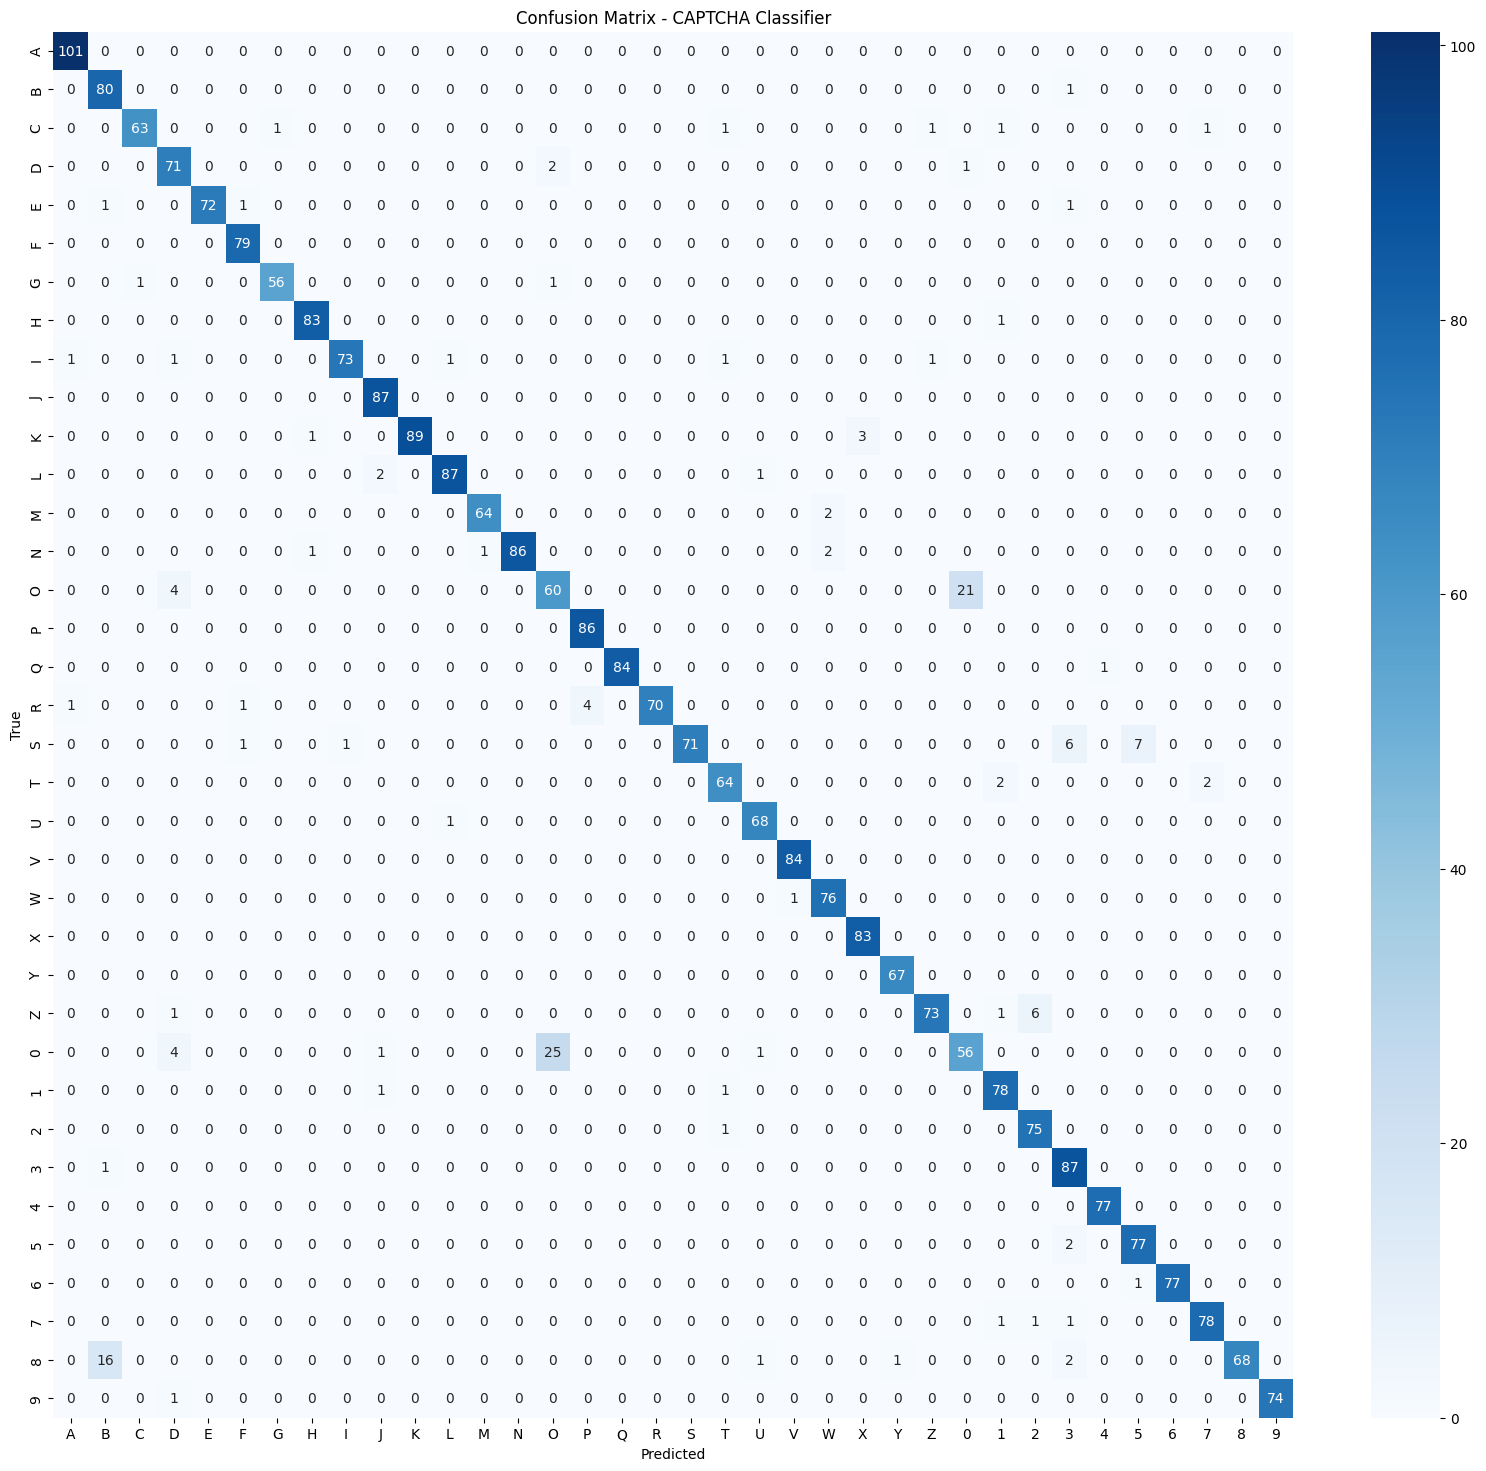

In [48]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels on test data
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot
plt.figure(figsize=(20,18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=characters, yticklabels=characters)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - CAPTCHA Classifier')
plt.show()

MISCLASSIFIED EXAMPLES

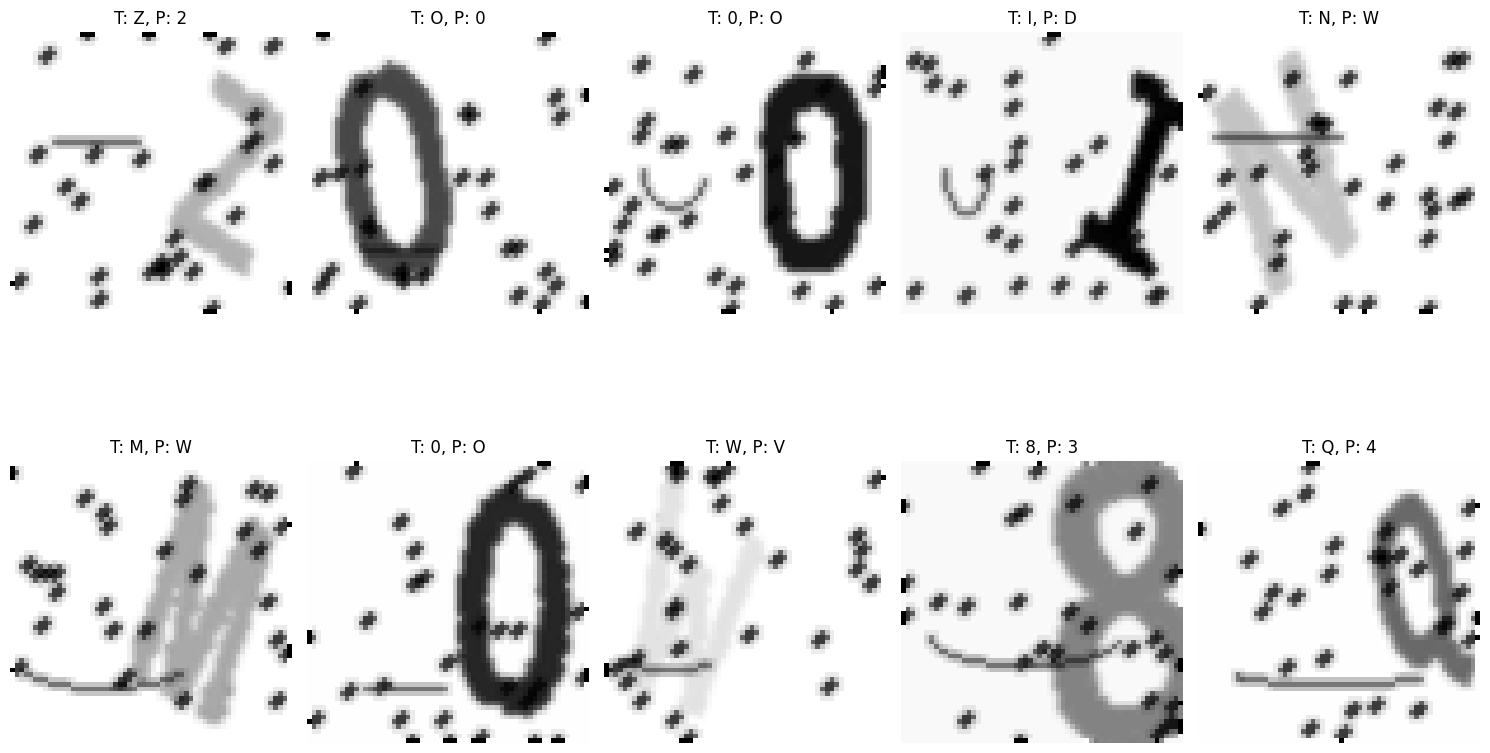

In [49]:
import random

def show_misclassified(X, y_true, y_pred, n=10):
    count = 0
    plt.figure(figsize=(15,10))
    for i in range(len(X)):
        true = y_true[i]
        pred = y_pred[i]
        if true != pred:
            count += 1
            plt.subplot(2, 5, count)
            plt.imshow(X[i].reshape(60,60), cmap="gray")
            plt.title(f"T: {characters[true]}, P: {characters[pred]}")
            plt.axis("off")
            if count == n:
                break
    plt.tight_layout()
    plt.show()

# Call the function
show_misclassified(X_test, y_true_labels, y_pred_labels)
